# 02 - Címke Elemzés (Label Analysis)
A Label Studio-ból exportált `labels.json` feldolgozása. Megvizsgáljuk, hány annotáció van, milyen az eloszlásuk típusok szerint (Normal, Pennant, Wedge), és milyen hosszúak ezek az alakzatok.

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

# Útvonalak
DATA_DIR = "../data" if os.path.exists("../data") else "/app/data"

# Minden labels.json megkeresése
label_files = glob.glob(os.path.join(DATA_DIR, "**", "*.json"), recursive=True)
print(f"Talált címke fájlok: {len(label_files)}")

all_data = []
for lf in label_files:
    try:
        with open(lf, 'r') as f:
            tasks = json.load(f)
            print(f" - {os.path.relpath(lf, DATA_DIR)}: {len(tasks)} task")
            all_data.extend(tasks)
    except Exception as e:
        print(f"Hiba {lf}: {e}")

print(f"Összesen {len(all_data)} annotált task.")

Talált címke fájlok: 6
 - AY1PC8\labels.json: 2 task
 - GFTYRV\labels.json: 27 task
 - J2QIYD\labels.json: 60 task
 - LMIRPG\LMIRPG.json: 2 task
 - XOBJYX\labels.json: 3 task
 - YH6M5S\labels.json: 1 task
Összesen 95 annotált task.


In [7]:
def parse_annotation_time(time_val):
    """
    Egyetlen JSON időérték biztonságos parse-olása.
    """
    if time_val is None:
        return None
    try:
        numeric_ts = float(time_val)
        if numeric_ts > 3e10: 
            return pd.to_datetime(numeric_ts, unit='ms')
        else:
            return pd.to_datetime(numeric_ts, unit='s')
    except (ValueError, TypeError):
        return pd.to_datetime(time_val)

stats = []

for task in all_data:
    filename = task.get('file_upload', 'Unknown')
    
    for ann in task.get('annotations', []):
        for res in ann.get('result', []):
            val = res.get('value', {})
            labels = val.get('timeserieslabels', [])
            
            if labels:
                label_name = labels[0]
                
                # --- JAVÍTOTT RÉSZ ---
                start = parse_annotation_time(val.get('start'))
                end = parse_annotation_time(val.get('end'))
                # ---------------------
                
                if start is None or end is None:
                    continue
                
                # Hossz számítása
                duration_mins = (end - start).total_seconds() / 60
                
                # Feltételezzük, hogy az adatok 5 percesek
                candle_count = int(duration_mins / 5)
                if candle_count < 1: candle_count = 1
                
                stats.append({
                    'File': filename,
                    'Label': label_name,
                    'Candle_Count': candle_count,
                    'Duration_Min': duration_mins
                })

df_stats = pd.DataFrame(stats)
print(f"Összes annotáció (Label): {len(df_stats)}")
df_stats.head()

Összes annotáció (Label): 358


,File,Label,Candle_Count,Duration_Min
0,351f4d2a-EURUSD_1H_005.csv,Bearish Normal,216,1080.0
1,351f4d2a-EURUSD_1H_005.csv,Bearish Normal,1,0.0
2,351f4d2a-EURUSD_1H_005.csv,Bullish Normal,240,1200.0
3,351f4d2a-EURUSD_1H_005.csv,Bullish Normal,180,900.0
4,7175fb3f-EURUSD_1min_001.csv,Bearish Normal,11,57.0


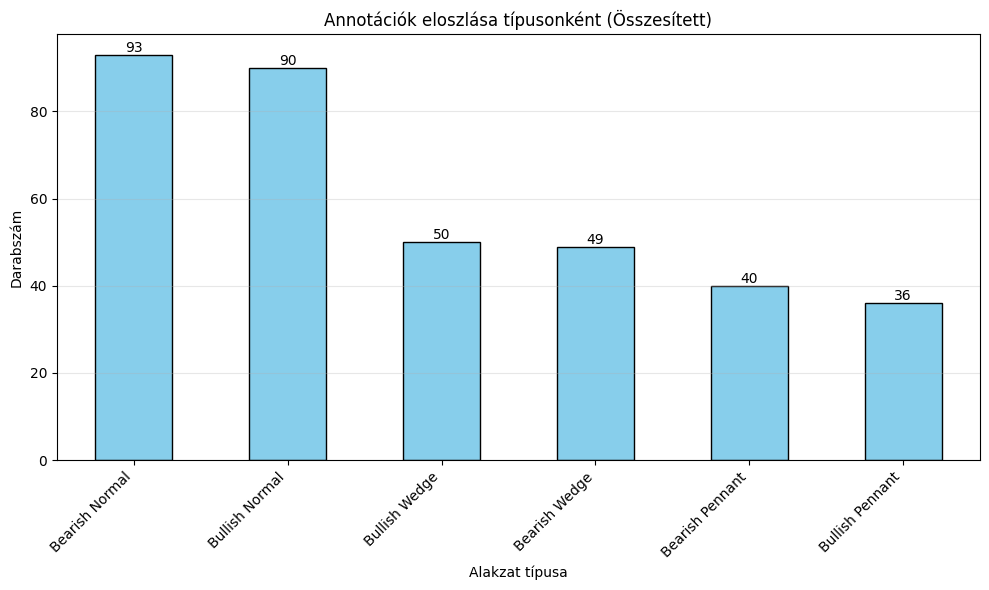

In [8]:
plt.figure(figsize=(10, 6))
ax = df_stats['Label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Annotációk eloszlása típusonként (Összesített)")
plt.xlabel("Alakzat típusa")
plt.ylabel("Darabszám")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

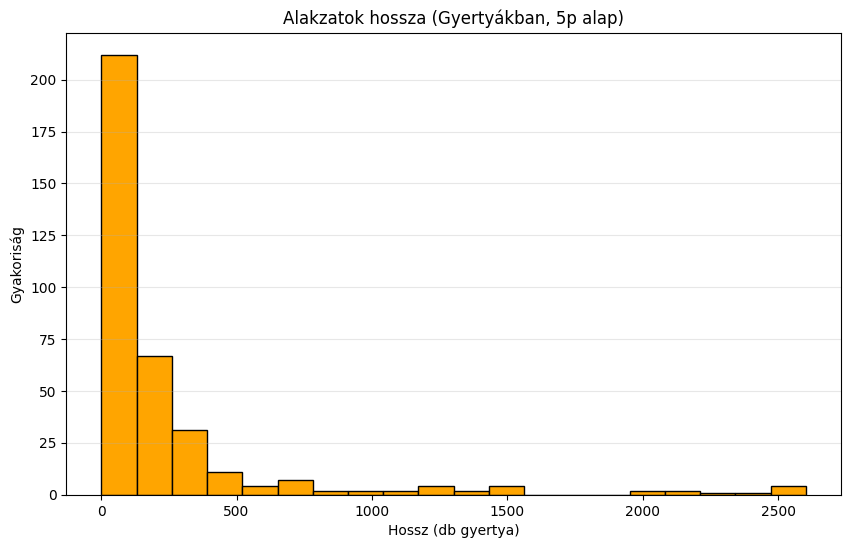

Átlagos hossz: 242.6536312849162
Min: 1
Max: 2602


In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df_stats['Candle_Count'], bins=20, color='orange', edgecolor='black')

plt.title("Alakzatok hossza (Gyertyákban, 5p alap)")
plt.xlabel("Hossz (db gyertya)")
plt.ylabel("Gyakoriság")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Átlagos hossz:", df_stats['Candle_Count'].mean())
print("Min:", df_stats['Candle_Count'].min())
print("Max:", df_stats['Candle_Count'].max())